In [1]:
## This notebook is to test whethere we can separate the lab tech and babies from the recordings of mothers

In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
from random import seed, shuffle
import os

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
sns.set_theme(style="white")

from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from sklearn.cluster import KMeans, SpectralClustering

from scipy import stats
from scipy.spatial.distance import directed_hausdorff, euclidean, cosine, pdist

from src.downsample import downsamp_audio
import src.embedding_extractor as ee
import src.dimension_reducer as dr
import src.distance_metrics as dm

from IPython.display import clear_output

import warnings
warnings.filterwarnings('ignore')

toy = '/Users/rahulbrito/Documents/projects/infantvoice/data/Full_Readings/0300222_recordings_16khz/001.wav'

Using cache found in /Users/rahulbrito/.cache/torch/hub/pyannote_pyannote-audio_master
Using cache found in /Users/rahulbrito/.cache/torch/hub/pyannote_pyannote-audio_master


In [3]:
toy

'/Users/rahulbrito/Documents/projects/infantvoice/data/Full_Readings/0300222_recordings_16khz/001.wav'

In [4]:
import torch
# speech activity detection model trained on AMI training set
sad = torch.hub.load('pyannote/pyannote-audio', 'sad_ami')
# speaker change detection model trained on AMI training set
scd = torch.hub.load('pyannote/pyannote-audio', 'scd_ami')
# overlapped speech detection model trained on AMI training set
ovl = torch.hub.load('pyannote/pyannote-audio', 'ovl_ami')
# speaker embedding model trained on AMI training set
emb = torch.hub.load('pyannote/pyannote-audio', 'emb_ami')

Using cache found in /Users/rahulbrito/.cache/torch/hub/pyannote_pyannote-audio_master
Using cache found in /Users/rahulbrito/.cache/torch/hub/pyannote_pyannote-audio_master
Using cache found in /Users/rahulbrito/.cache/torch/hub/pyannote_pyannote-audio_master


  0%|          | 0.00/2.41M [00:00<?, ?B/s]

Using cache found in /Users/rahulbrito/.cache/torch/hub/pyannote_pyannote-audio_master


In [5]:
test_file = {'uri': 'filename', 'audio': toy}

In [6]:
test_file

{'uri': 'filename',
 'audio': '/Users/rahulbrito/Documents/projects/infantvoice/data/Full_Readings/0300222_recordings_16khz/001.wav'}

In [7]:
# obtain raw SAD scores (as `pyannote.core.SlidingWindowFeature` instance)
sad_scores = sad(test_file)

# binarize raw SAD scores
# NOTE: both onset/offset values were tuned on AMI dataset.
# you might need to use different values for better results.
from pyannote.audio.utils.signal import Binarize
binarize = Binarize(offset=0.52, onset=0.52, log_scale=True, 
                    min_duration_off=0.1, min_duration_on=0.1)

# speech regions (as `pyannote.core.Timeline` instance)
speech = binarize.apply(sad_scores, dimension=1)

In [8]:
# obtain raw SCD scores (as `pyannote.core.SlidingWindowFeature` instance)
scd_scores = scd(test_file)

# detect peaks and return speaker homogeneous segments 
# NOTE: both alpha/min_duration values were tuned on AMI dataset.
# you might need to use different values for better results.
from pyannote.audio.utils.signal import Peak
peak = Peak(alpha=0.10, min_duration=0.10, log_scale=True)

# speaker change point (as `pyannote.core.Timeline` instance)
partition = peak.apply(scd_scores, dimension=1)

In [9]:
# obtain raw OVL scores (as `pyannote.core.SlidingWindowFeature` instance)
ovl_scores = ovl(test_file)

# binarize raw OVL scores
# NOTE: both onset/offset values were tuned on AMI dataset.
# you might need to use different values for better results.
from pyannote.audio.utils.signal import Binarize
binarize = Binarize(offset=0.55, onset=0.55, log_scale=True, 
                    min_duration_off=0.1, min_duration_on=0.1)

# overlapped speech regions (as `pyannote.core.Timeline` instance)
overlap = binarize.apply(ovl_scores, dimension=1)

Text(120.5, 0.1, 'overlapped speech detection')

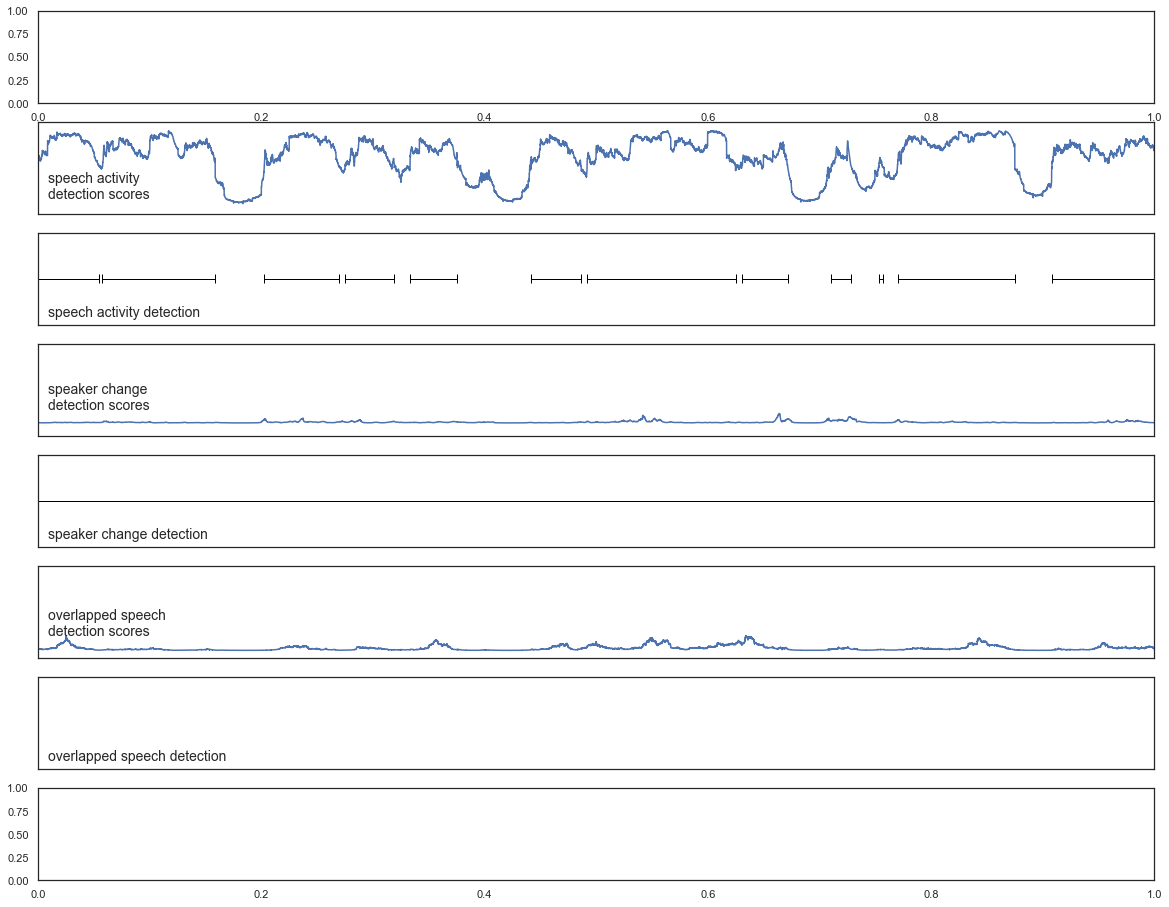

In [16]:
# let's visualize SAD, SCD and OVL results using pyannote.core visualization API
import numpy as np
from matplotlib import pyplot as plt
from pyannote.core import Segment, notebook

# only plot one minute (between t=120s and t=180s)
#notebook.crop = Segment(120, 180)

# helper function to make visualization prettier
from pyannote.core import SlidingWindowFeature
plot_ready = lambda scores: SlidingWindowFeature(np.exp(scores.data[:, 1:]), scores.sliding_window)

# create a figure with 8 rows with matplotlib
nrows = 8
fig, ax = plt.subplots(nrows=nrows, ncols=1)
fig.set_figwidth(20)
fig.set_figheight(nrows * 2)

# 1st row: reference annotation
#notebook.plot_annotation(test_file['annotation'], ax=ax[0], time=False)
#ax[0].text(notebook.crop.start + 0.5, 0.1, 'reference', fontsize=14)

# 2nd row: SAD raw scores
notebook.plot_feature(plot_ready(sad_scores), ax=ax[1], time=False)
ax[1].text(notebook.crop.start + 0.5, 0.1, 'speech activity\ndetection scores', fontsize=14)
ax[1].set_ylim(-0.1, 1.1)

# 3rd row: SAD result
notebook.plot_timeline(speech, ax=ax[2], time=False)
ax[2].text(notebook.crop.start + 0.5, 0.1, 'speech activity detection', fontsize=14)

# 4th row: SCD raw scores
notebook.plot_feature(plot_ready(scd_scores), ax=ax[3], time=False)
ax[3].text(notebook.crop.start + 0.5, 0.1, 'speaker change\ndetection scores', fontsize=14)
ax[3].set_ylim(-0.1, 0.6)

# 5th row: SCD result
notebook.plot_timeline(partition, ax=ax[4], time=False)
ax[4].text(notebook.crop.start + 0.5, 0.1, 'speaker change detection', fontsize=14)

# 6th row: OVL raw scores
notebook.plot_feature(plot_ready(ovl_scores), ax=ax[5], time=False)
ax[5].text(notebook.crop.start + 0.5, 0.2, 'overlapped speech\ndetection scores', fontsize=14)
ax[5].set_ylim(-0.1, 1.1)

# 7th row: OVL result
notebook.plot_timeline(overlap, ax=ax[6], time=False)
ax[6].text(notebook.crop.start + 0.5, 0.1, 'overlapped speech detection', fontsize=14)

# 8th row: reference annotation
#notebook.plot_annotation(test_file['annotation'], ax=ax[7], legend=False)
#_ = ax[7].text(notebook.crop.start + 0.5, 0.1, 'reference', fontsize=14)

In [27]:
# speech turns are simply the intersection of SAD and SCD
speech_turns = partition.crop(speech)
# obtain raw embeddings (as `pyannote.core.SlidingWindowFeature` instance)
embeddings = emb(test_file)

chunks = embeddings.sliding_window
print(f'Embeddings were extracted every {1000 * chunks.step:g}ms on {1000 * chunks.duration:g}ms-long windows.')
# for the purpose of this tutorial, we only work of long (> 1s) speech turns
from pyannote.core import Timeline
long_turns = Timeline(segments=[s for s in speech_turns if s.duration > 2.])
#Extracting embedding for a given speech turn is as easy as embedding.crop(segment):

X, Y = [], []
for segment in long_turns:
    # "strict" only keeps embedding strictly included in segment
    x = embeddings.crop(segment, mode='strict')
    # average speech turn embedding
    X.append(np.mean(x, axis=0))

    # keep track of speaker label (for later scatter plot)
    #y = test_file['annotation'].argmax(segment)
    #Y.append(y)

X = np.vstack(X)
#_, y_true = np.unique(Y, return_inverse=True)

Embeddings were extracted every 500ms on 2000ms-long windows.


In [28]:
type(embeddings)

pyannote.core.feature.SlidingWindowFeature